In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from sklearn.model_selection import train_test_split, KFold
# from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet18

In [124]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations

transform_greyscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.1])
])


In [125]:
# Define additional transformations for edge detection
class ScharrEdgeDetection(object):
    def __call__(self, img):
        img = img.numpy().squeeze(0)  # Convert tensor to numpy array and remove channel dimension
        grad_x = cv2.Scharr(img, cv2.CV_64F, 1, 0)
        grad_y = cv2.Scharr(img, cv2.CV_64F, 0, 1)
        scharr_edges = cv2.magnitude(grad_x, grad_y)
        scharr_edges = cv2.normalize(scharr_edges, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        return torch.tensor(scharr_edges, dtype=torch.float32).unsqueeze(0)  # Convert back to tensor and add channel dimension

# Custom dataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform_greyscale=None, edge_detection=None):
        self.dataset = ImageFolder(root=root)
        self.transform_greyscale = transform_greyscale
        self.edge_detection = edge_detection

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.imgs[idx]
        img = self.dataset.loader(path)

        if self.transform_greyscale:
            grey_img = self.transform_greyscale(img)
        if self.edge_detection:
            edge_img = self.edge_detection(grey_img)

        return edge_img, label

# Instantiate the dataset
train_dataset = CustomImageDataset(
    root='/content/drive/MyDrive/Dataset/TrainingSet/',
    transform_greyscale=transform_greyscale,
    edge_detection=ScharrEdgeDetection()
)


In [126]:
# Hyperparameters

batch_size=9
lr=0.001
num_epochs = 120
img_shape = (1, 224, 224)
num_classes = 2

In [127]:
# Load training dataset
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [128]:
# Example to show how to access images and labels

for edge_imgs, labels in dataloader:
    edge_imgs, labels = edge_imgs.to(device), labels.to(device)
    print(edge_imgs.shape, labels.shape)
    break

torch.Size([12, 1, 224, 224]) torch.Size([12])


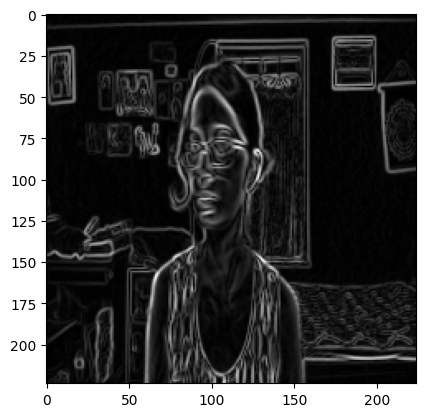

In [129]:
edge, label = train_dataset[0]
plt.imshow(edge.squeeze(0), cmap="gray")

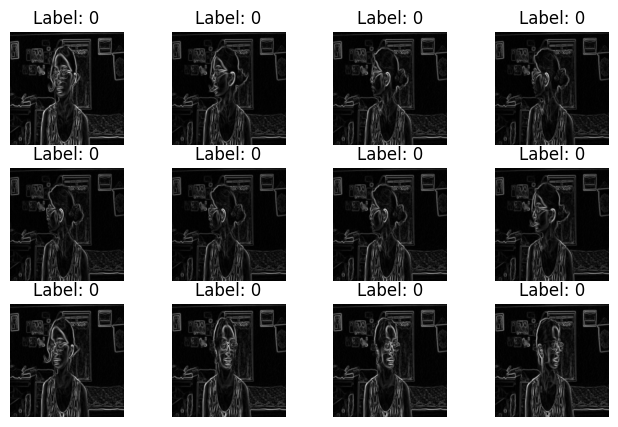

In [130]:
# edge, label = train_dataset[0]
# plt.imshow(edge.squeeze(0), cmap="gray")

plt.figure(figsize=(8, 5))
for i in range(12):
    edge_img, label = train_dataset[i]
    plt.subplot(3, 4, i+1)
    plt.imshow(edge_img.squeeze(0), cmap="gray")
    plt.title(f"Label: {label}")  # Add label as title
    plt.axis('off')  # Turn off axis labels
plt.show()

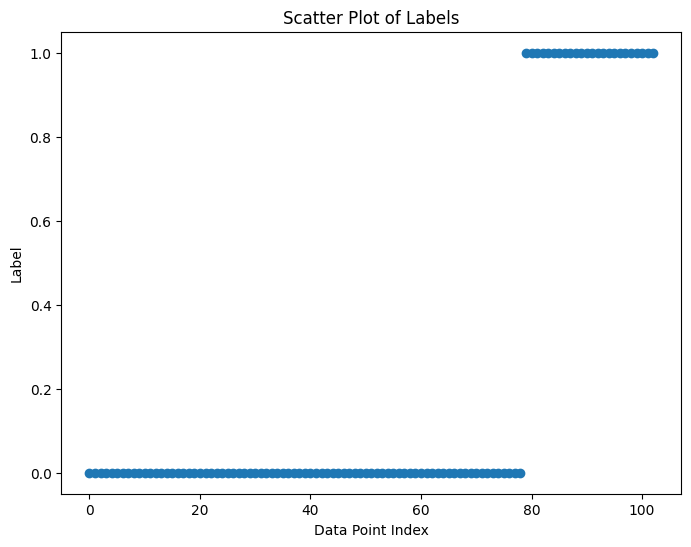

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [131]:
# Extract labels from the dataloader
arr = []
for _, label in dataloader:
  arr.extend(label.numpy())

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter([i for i in range(len(arr))], arr)
plt.xlabel("Data Point Index")
plt.ylabel("Label")
plt.title("Scatter Plot of Labels")
plt.show()
print(arr)

[79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


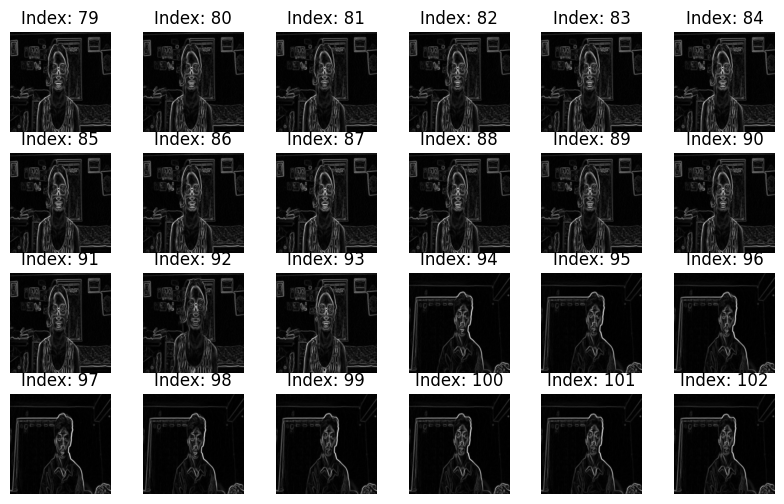

In [132]:

indices_with_one = [i for i, x in enumerate(arr) if x == 1]

# Print the indices
print(indices_with_one)

# Plot the corresponding images
plt.figure(figsize=(10, 6))
for i, index in enumerate(indices_with_one[:24]):  # Plot the first 12 images
    edge_img, label = train_dataset[index]
    plt.subplot(4, 6, i + 1)
    plt.imshow(edge_img.squeeze(0), cmap="gray")
    plt.title(f"Index: {index}")
    plt.axis('off')
plt.show()


# Model

In [138]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        # Load a pre-trained ResNet18 model
        self.model = resnet18(pretrained=True)

        # Modify the first convolutional layer to accept 1 channel instead of 3
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the output layer to match the number of classes (2 in this case)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

model = Model(num_classes=num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.1MB/s]


In [136]:
criterion = nn.CrossEntropyLoss()
kf = KFold(n_splits=12, shuffle=True, random_state=42)

In [ ]:
# Training loop with 12-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold+1}")

    # Create data loaders for the current fold
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize the model, optimizer, and move the model to the device
    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Training Accuracy: {correct/total}, Training Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {correct/total}")

Fold 1
Epoch 1/120
Training Accuracy: 0.648936170212766, Training Loss: 0.8649779334664345
Validation Loss: 0.27560409903526306, Validation Accuracy: 0.8888888888888888
Epoch 2/120
